<a href="https://colab.research.google.com/github/Molten-Ice/Deep-Learning/blob/dev/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import copy

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"on device: {device}")

on device: cuda


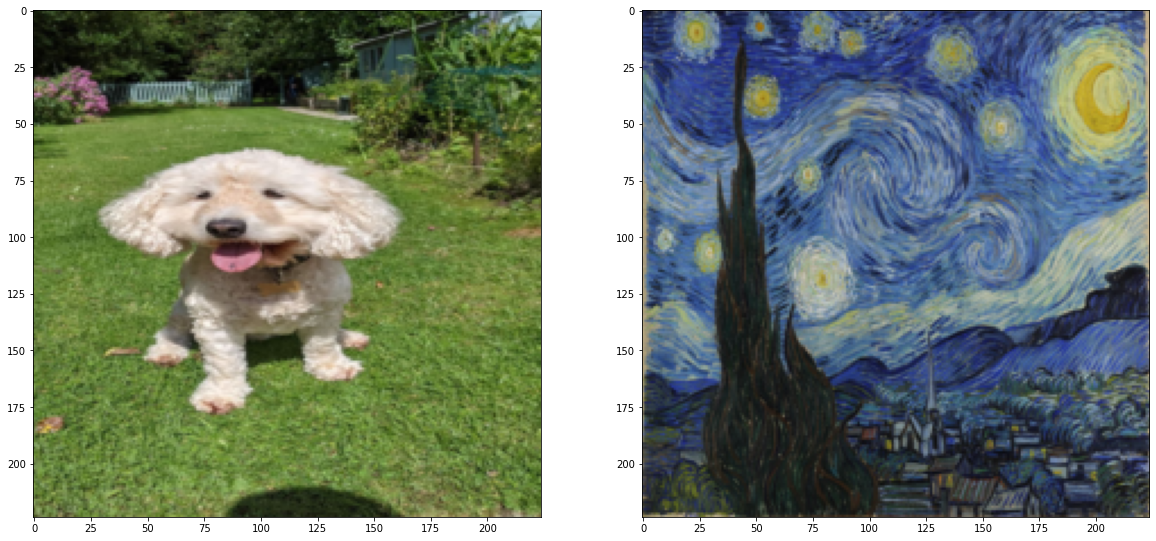

In [33]:
def load_image(image_path):
  in_transform = transforms.Compose([
                        transforms.Resize((224, 224)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
  image = Image.open(image_path)
  image = in_transform(image).unsqueeze(dim=0)
  return image.to(device)

# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

# content = load_image("/content/LondonEye.jpg")
content = load_image("/content/Sherlock.jpg")

style = load_image("/content/StarryNight.jpg")

# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [34]:
model = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.IMAGENET1K_V1).features[:29].to(device)
for param in model.parameters():
  param.requires_grad_(False)

In [37]:
def get_activations(model, x):
  activations = []
  output_idxs = [0, 5, 10, 19, 28]
  for layer_idx, layer in enumerate(model):
    x = layer(x)
    if layer_idx in output_idxs:
      activations.append(x)
  return activations

def calculate_gram(x):
  _, c, w, h = x.shape
  x = x.view(c, -1)
  return x @ x.T #/ (c * w * h)

content_activations = get_activations(model, content)
style_activations = get_activations(model, style)
style_grams = [calculate_gram(x) for x in style_activations]

generated = content.clone().requires_grad_(True).to(device)


Epoch: 0
loss: 121091.2344 | content(alpha) contribution: 0.0000 | style(beta) contribution: 121091.2400000


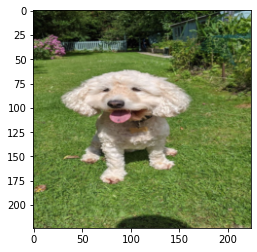


Epoch: 1000
loss: 1443.7822 | content(alpha) contribution: 2.0208 | style(beta) contribution: 1441.7615625


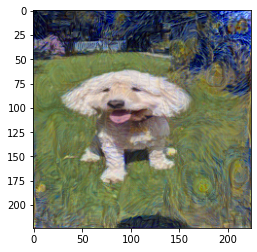


Epoch: 2000
loss: 788.2725 | content(alpha) contribution: 2.3162 | style(beta) contribution: 785.9563281


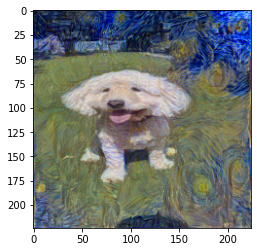


Epoch: 3000
loss: 624.3578 | content(alpha) contribution: 2.4696 | style(beta) contribution: 621.8882812


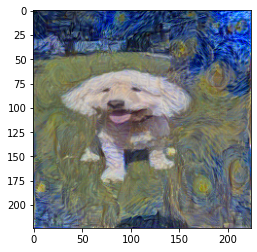


Epoch: 4000
loss: 546.1653 | content(alpha) contribution: 2.5812 | style(beta) contribution: 543.5841406


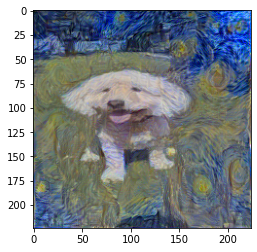


Epoch: 5000
loss: 509.5231 | content(alpha) contribution: 2.6617 | style(beta) contribution: 506.8614844


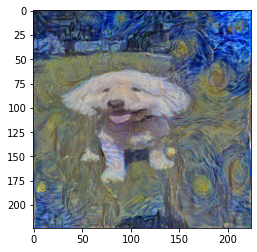


Epoch: 6000
loss: 500.8413 | content(alpha) contribution: 2.7285 | style(beta) contribution: 498.1127734


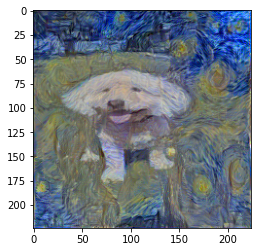


Epoch: 7000
loss: 459.4485 | content(alpha) contribution: 2.7785 | style(beta) contribution: 456.6700391


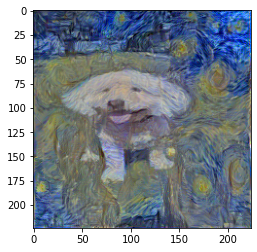


Epoch: 8000
loss: 446.1362 | content(alpha) contribution: 2.8403 | style(beta) contribution: 443.2958984


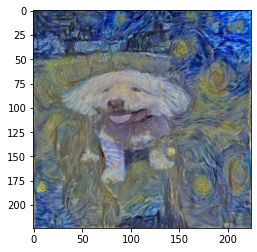


Epoch: 9000
loss: 430.2276 | content(alpha) contribution: 2.8796 | style(beta) contribution: 427.3480469


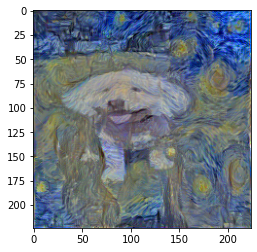

KeyboardInterrupt: ignored

In [38]:
alpha = 1
beta = 0.01
learning_rate = 1e-2
epochs = 20000
content_idx = 1
style_weights = [1, 0.75, 0.2, 0.2, 0.2]

optimizer = torch.optim.AdamW([generated], lr=learning_rate)
model.train()
for epoch in range(epochs):   
  generated_activations = get_activations(model, generated)
  content_loss = torch.mean((generated_activations[content_idx] - content_activations[content_idx])**2)

  style_loss = 0
  generated_grams = [calculate_gram(x) for x in generated_activations]
  for i, (g, s) in enumerate(zip(generated_grams, style_grams)):
    _, c, w, h = generated_activations[i].shape
    style_loss+=style_weights[i]*torch.sum((g-s)**2) / ((c*w*h)**2)

  loss = alpha*content_loss + beta*style_loss

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # display intermediate images and print the loss
  if epoch % 1000 == 0:
      print(f"\nEpoch: {epoch}")
      print(f"loss: {loss.item():.4f} | content(alpha) contribution: {alpha*content_loss.item():.4f} | style(beta) contribution: {beta*style_loss.item():.7f}")
      plt.imshow(im_convert(generated))
      plt.show()